# Utilities

In this lesson, we will explore useful utilities in PyTorch like [Data Loaders](https://pytorch.org/docs/stable/data.html), [LR Schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), Model Checkpoints, Early Stopping, [TensorBoard](https://www.tensorflow.org/tensorboard) and hyperparameter tuning.

<div align="left">
<a href="https://github.com/madewithml/lessons/blob/master/notebooks/02_Basics/05_Utilities/05_PT_Utilities.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/lessons/blob/master/notebooks/02_Basics/05_Utilities/05_PT_Utilities.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

* **Data Loaders**: create custom datasets and loaders to use during training.
* **LR Schedulers**: adjust the learning rate while training.
* **Model Checkpoints**: saving our model when a certain performance metric (ex. validation loss) improves.
* **Early Stopping**: ending training early if a certain metric (ex. validation loss) get worse for a certain # number of epochs. 
* **TensorBoard**: tool to visualize metrics, weights, gradients, model architecture, hyperparameter optimization, etc.
* **Hyperparameter tuning**: experimenting with different hyperparameter to see what combination yields the best validation performance.

# Data

## Load data

Let's download and process our non-linear spiral data for a classification task.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [2]:
SEED = 1234
DATA_FILE = "spiral.csv"

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)

In [11]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/spiral.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [12]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[['X1', 'X2']].values
y = df['color'].values
df.head(5)

,X1,X2,color
0,0.000000,0.000000,c1
1,-0.000457,0.001951,c1
2,0.001194,0.003826,c1
3,-0.000231,0.006008,c1
4,-0.000896,0.007966,c1


In [13]:
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


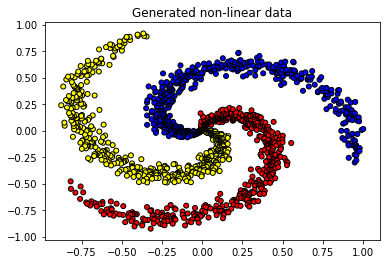

In [14]:
# Visualize data
plt.title("Generated non-linear data")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

## Split data

In [15]:
import collections
from sklearn.model_selection import train_test_split

In [16]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [17]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [18]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (1083, 2), y_train: (1083,)
X_val: (192, 2), y_val: (192,)
X_test: (225, 2), y_test: (225,)
Sample point: [ 0.23623443 -0.59618506] → c1
Classes: {'c1': 500, 'c3': 500, 'c2': 500}


## Label encoder

In [19]:
import json
from sklearn.preprocessing import LabelEncoder

In [20]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [21]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [22]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [23]:
# Class weights
counts = collections.Counter(y_train)
class_weights = {_class: 1.0/count for _class, count in counts.items()}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: Counter({0: 361, 2: 361, 1: 361}),
class weights: {0: 0.002770083102493075, 2: 0.002770083102493075, 1: 0.002770083102493075}


## Standardize data

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [26]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [27]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train[0]: mean: {np.mean(X_train[:, 0], axis=0):.1f}, std: {np.std(X_train[:, 0], axis=0):.1f}")
print (f"X_train[1]: mean: {np.mean(X_train[:, 1], axis=0):.1f}, std: {np.std(X_train[:, 1], axis=0):.1f}")
print (f"X_val[0]: mean: {np.mean(X_val[:, 0], axis=0):.1f}, std: {np.std(X_val[:, 0], axis=0):.1f}")
print (f"X_val[1]: mean: {np.mean(X_val[:, 1], axis=0):.1f}, std: {np.std(X_val[:, 1], axis=0):.1f}")
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_train[0]: mean: 0.0, std: 1.0
X_train[1]: mean: 0.0, std: 1.0
X_val[0]: mean: 0.1, std: 1.0
X_val[1]: mean: 0.0, std: 1.0
X_test[0]: mean: 0.1, std: 1.0
X_test[1]: mean: -0.1, std: 0.9


# Data Loaders

[Dataset Loaders](https://pytorch.org/docs/stable/data.html) will allow us to create batches for training, validation and testing. These loaders become very useful when we want to apply batch-specific operations on our data.

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

ImportError: DLL load failed with error code 3221225501

In [0]:
# Set seed for reproducibility
torch.manual_seed(SEED)

In [0]:
BATCH_SIZE = 32

In [0]:
class SpiralDataset(Dataset):
    """Spiral dataset."""
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y
    
    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

In [0]:
# Create datasets
train_set = SpiralDataset(X=X_train, y=y_train)
val_set = SpiralDataset(X=X_val, y=y_val)
test_set = SpiralDataset(X=X_test, y=y_test)
print (train_set)
print (train_set[0])

<Dataset(N=1083)>
(array([ 0.6392495, -1.3974285], dtype=float32), 0)


In [0]:
# Data Loaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=False) 
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False) 

In [0]:
# Iterating through a data loader
for i, (X, y) in enumerate(test_loader):
    print (f"batch {i} | X [{X.type()}]: {X.shape}, y [{y.type()}]: {y.shape}")

batch 0 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 1 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 2 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 3 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 4 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 5 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 6 | X [torch.FloatTensor]: torch.Size([32, 2]), y [torch.LongTensor]: torch.Size([32])
batch 7 | X [torch.FloatTensor]: torch.Size([1, 2]), y [torch.LongTensor]: torch.Size([1])


**NOTE**: So far, we used batch gradient descent to update our weights. This means that we calculated the gradients using the entire training dataset. We also could've updated our weights using stochastic gradient descent (SGD) where we pass in one training example one at a time. The current standard is mini-batch gradient descent, which strikes a balance between batch and stochastic GD, where we update the weights using a mini-batch of n (`BATCH_SIZE`) samples.

# Device configuration

So far we've been running our operations on the CPU but when we have large datasets and larger models to train, we can benefit by parallelzing tensor operations on a GPU. In this notebook, you can use a GPU by going to `Runtime` > `Change runtime type` > Select `GPU` in the `Hardware accelerator` dropdown. We can what device we're using with the following line of code:

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


# Model

In [0]:
import math
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [0]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(classes)
NUM_EPOCHS = 10

In [0]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        y_pred = self.fc2(z)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1) 
        return y_pred

In [0]:
# Initialize model (and set device)
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES).to(device)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,))

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
           Dropout-2                  [-1, 100]               0
            Linear-3                    [-1, 3]             303
Total params: 603
Trainable params: 603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [0]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [0]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

# LR scheduler

We're going to add a learning rate scheduler to our optimizer to adjust our learning rate during training. There are [many](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) schedulers to choose from but a popular one is `ReduceLROnPlateau` - reduce the learning rate when a metric (ex. validation loss) stops improving. In the example below we'll reduce the learning rate by a factor of 0.1 (`factor=0.1`) when our metrics stops decreasing (`mode='min'`) for 3 (`patience=3`) straight epochs. In our trainig loop, we'll add the line `scheduler.step(running_val_loss)` to make validation loss the metric to focus on.

In [0]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [0]:
LEARNING_RATE = 1e-2

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Model checkpoints

We don't want to train our model and only save it at the end but instead we want to check the performance (ex. validation loss) after every epoch and save the model is performance is better than all the previous runs. This is important since performance can degrade during subsequent epochs.

```python
# Save model
torch.save(model.state_dict(), PATH)
```

```python
# Load model
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

# Early stopping

Sometimes we don't want to train our model for `NUM_EPOCHS` and we'll want to stop early when performance no longer continue to improve. This is know as early stopping and we stop training by monitoring a specific metric (ex. validation loss) and seeing if it continues to get worse for a certain number of epochs (patience). 

In [0]:
PATIENCE = 3 

```python
best_val_loss = np.inf

for epoch in range(NUM_EPOCHS):

    train_batch()
    validation_batch()

    ...

    # Early stopping
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        patience = PATIENCE # reset patience
        save_model() # save model
    else:
        patience -= 1
    if not patience: # 0
        print ("Stopping early!")
        break
```

# TensorBoard

TensorBoard is a tool to visualize models, data and training.

In [0]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [0]:
# Create writer to store values 
log_dir = 'tensorboard/spiral_MLP'
!rm -rf log_dir # remove if it already exists
writer = SummaryWriter(log_dir=log_dir)

In [0]:
# Write model
inputs, outputs = next(iter(train_loader))
writer.add_graph(model, inputs.to(device))

In the training section below, we'll see how to write scalars (loss, accuracy, etc.), historgram (model weight distributions), hyperparameters, etc.

```python
# Scalars
writer.add_scalar(tag='training loss', scalar_value=running_train_loss, global_step=epoch)

# Histograms
writer.add_histogram(tag="fc1", values=model.fc1.weight, global_step=epoch)

# Hyperparamters
hparams = {
    'batch_size': BATCH_SIZE, 
    'hidden_dim': HIDDEN_DIM, 
    'dropout_p': DROPOUT_P, 
    'learning_rate': LEARNING_RATE
}
writer.add_hparams(hparam_dict=hparams, metric_dict={'val_loss': val_loss})
```

# Training

We're going to create functions in a trainer class to do all of the training, validation and testing.

In [0]:
MODEL_PATH = 'model.pth'

In [0]:
class Trainer(object):

    def __init__(self, **kwargs):
        self.__dict__ = kwargs

    def train_loop(self, num_epochs):
        """Training and validation steps."""
        # Metrics
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        best_val_loss = np.inf

        # Epochs
        for epoch in range(num_epochs):
            # Steps
            self.train_step(epoch)
            self.val_step(epoch)
            print (f"Epoch: {epoch} | train_loss: {self.train_loss[-1]:.2f}, train_acc: {self.train_acc[-1]:.1f}, val_loss: {self.val_loss[-1]:.2f}, val_acc: {self.val_acc[-1]:.1f}")

            # Early stopping
            if self.val_loss[-1] < best_val_loss:
                best_val_loss = self.val_loss[-1]
                patience = self.patience # reset patience

                # Save model
                torch.save(model.state_dict(), self.model_path)
                
            else:
                patience -= 1
            if not patience: # 0
                print ("Stopping early!")
                break

        return self.train_loss, self.train_acc, self.val_loss, self.val_acc, best_val_loss

    def train_step(self, epoch):
        """Training one epoch."""
        # Set model to train mode
        self.model.train()

        # Reset batch metrics
        running_train_loss = 0.0
        running_train_acc = 0.0

        # Iterate over train batches
        for i, (X, y) in enumerate(self.train_loader):

            # Cast
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y)

            # Backward pass + optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_train_loss += (loss - running_train_loss) / (i + 1)
            running_train_acc += (accuracy - running_train_acc) / (i + 1)
        
        # Update epoch metrics
        self.train_loss.append(running_train_loss)
        self.train_acc.append(running_train_acc)

        # Write to TensorBoard
        self.writer.add_scalar(tag='training loss', scalar_value=running_train_loss, global_step=epoch)
        self.writer.add_scalar(tag='training accuracy', scalar_value=running_train_acc, global_step=epoch)
        self.writer.add_histogram(tag="fc1", values=self.model.fc1.weight, global_step=epoch)

    def val_step(self, epoch):
        """Validate one epoch."""
        # Set model to eval mode
        self.model.eval()

        # Reset batch metrics
        running_val_loss = 0.0
        running_val_acc = 0.0

        # Iterate over val batches
        for i, (X, y) in enumerate(self.val_loader):
            
            # Cast
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            with torch.no_grad():
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_val_loss += (loss - running_val_loss) / (i + 1)
            running_val_acc += (accuracy - running_val_acc) / (i + 1)

        # Update epoch metrics
        self.val_loss.append(running_val_loss)
        self.val_acc.append(running_val_acc)

        # Write to TensorBoard
        self.writer.add_scalar(tag='validation loss', scalar_value=running_val_loss, global_step=epoch)
        self.writer.add_scalar(tag='validation accuracy', scalar_value=running_val_acc, global_step=epoch)

        # Adjust learning rate
        self.scheduler.step(running_val_loss)

    def test_loop(self):
        """Evalution of the test set."""
        # Metrics
        running_test_loss = 0.0
        running_test_acc = 0.0

        # Iterate over val batches
        for i, (X, y) in enumerate(self.test_loader):
            
            # Cast
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            with torch.no_grad():
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_test_loss += (loss - running_test_loss) / (i + 1)
            running_test_acc += (accuracy - running_test_acc) / (i + 1)

        return running_test_loss, running_test_acc

In [0]:
# Initialize
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
            dropout_p=DROPOUT_P, num_classes=NUM_CLASSES).to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [0]:
# Train
trainer = Trainer(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, 
                  model=model, optimizer=optimizer, scheduler=scheduler, 
                  loss_fn=loss_fn, accuracy_fn=accuracy_fn, patience=PATIENCE, 
                  model_path=MODEL_PATH, writer=writer, device=device)
train_loss, train_acc, val_loss, val_acc, best_val_loss = trainer.train_loop(num_epochs=NUM_EPOCHS)

Epoch: 0 | train_loss: 0.68, train_acc: 58.4, val_loss: 0.52, val_acc: 71.9
Epoch: 1 | train_loss: 0.40, train_acc: 86.5, val_loss: 0.34, val_acc: 87.0
Epoch: 2 | train_loss: 0.25, train_acc: 93.3, val_loss: 0.24, val_acc: 92.2
Epoch: 3 | train_loss: 0.18, train_acc: 94.9, val_loss: 0.19, val_acc: 94.3
Epoch: 4 | train_loss: 0.15, train_acc: 95.7, val_loss: 0.15, val_acc: 97.4
Epoch: 5 | train_loss: 0.12, train_acc: 96.9, val_loss: 0.14, val_acc: 96.4
Epoch: 6 | train_loss: 0.10, train_acc: 97.1, val_loss: 0.11, val_acc: 97.9
Epoch: 7 | train_loss: 0.10, train_acc: 96.5, val_loss: 0.11, val_acc: 99.0
Epoch: 8 | train_loss: 0.09, train_acc: 97.7, val_loss: 0.10, val_acc: 96.9
Epoch: 9 | train_loss: 0.08, train_acc: 97.6, val_loss: 0.09, val_acc: 97.9


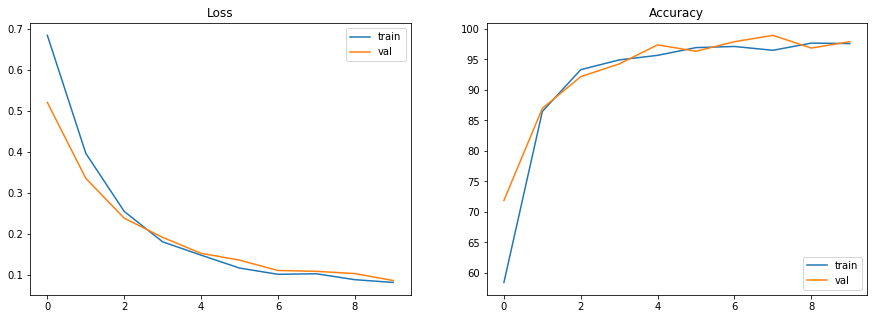

In [0]:
# Plot performance
plt.figure(figsize=(15,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend(loc='upper right')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(train_acc, label="train")
plt.plot(val_acc, label="val")
plt.legend(loc='lower right')

# Show plots
plt.show()

In [0]:
# Evaluation
test_loss, test_acc = trainer.test_loop()
print (f"test_loss: {test_loss:.2f}, test_acc: {test_acc:.1f}")

test_loss: 0.07, test_acc: 98.8


In [0]:
# Visualize performance on tensorboard
%tensorboard --logdir tensorboard

In [0]:
# Let's see our saved model
!ls

model.pth  sample_data	spiral.csv  tensorboard


In [0]:
# Load model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

# Hyperparameter Optimization

How do we know that the parameters (like *HIDDEN_DIM*, *DROPOUT_P*, *LEARNING_RATE*, etc.) we chose for our model are the best? We can empirically validate by doing hyperparameter optimization with TensorBoard. We will just try a few hyperparameter values but you can see the results and fine tune ever more.

In [0]:
hidden_dim_list = [50, 100, 200]
dropout_p_list = [0.0, 0.1, 0.2]
learning_rate_list = [1e-1, 1e-2, 1e-3]

In [0]:
model_num = 0
for hidden_dim in hidden_dim_list:
    for dropout_p in dropout_p_list:
        for learning_rate in learning_rate_list:

            # Create writer to store values 
            log_dir = f'tensorboard/hparam_tuning/spiral_MLP_{model_num}'
            print (f"\nMODEL_NUM: {model_num}, hidden_dim: {hidden_dim}, dropout_p: {dropout_p}, learning_rate: {learning_rate}")
            model_num += 1
            writer = SummaryWriter(log_dir=log_dir)

            # Initialize
            model = MLP(input_dim=INPUT_DIM, hidden_dim=hidden_dim, 
                        dropout_p=DROPOUT_P, num_classes=NUM_CLASSES).to(device)
            optimizer = Adam(model.parameters(), lr=learning_rate) 
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

            # Train
            trainer = Trainer(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, 
                              model=model, optimizer=optimizer, scheduler=scheduler, 
                              loss_fn=loss_fn, accuracy_fn=accuracy_fn, patience=PATIENCE, 
                              model_path=MODEL_PATH, writer=writer, device=device)
            train_loss, train_acc, val_loss, val_acc, best_val_loss = trainer.train_loop(num_epochs=NUM_EPOCHS)


            # Write hyperparamters to TensorBoard
            hparams = {
                'hidden_dim': hidden_dim, 
                'dropout_p': dropout_p, 
                'learning_rate': learning_rate
            }
            writer.add_hparams(hparam_dict=hparams, metric_dict={'val_loss': best_val_loss})


MODEL_NUM: 0, hidden_dim: 50, dropout_p: 0.0, learning_rate: 0.1
Epoch: 0 | train_loss: 0.56, train_acc: 74.4, val_loss: 0.30, val_acc: 85.9
Epoch: 1 | train_loss: 0.23, train_acc: 91.4, val_loss: 0.16, val_acc: 93.8
Epoch: 2 | train_loss: 0.18, train_acc: 93.1, val_loss: 0.14, val_acc: 94.8
Epoch: 3 | train_loss: 0.14, train_acc: 94.9, val_loss: 0.10, val_acc: 96.9
Epoch: 4 | train_loss: 0.11, train_acc: 95.3, val_loss: 0.08, val_acc: 98.4
Epoch: 5 | train_loss: 0.12, train_acc: 96.1, val_loss: 0.09, val_acc: 97.4
Epoch: 6 | train_loss: 0.15, train_acc: 95.7, val_loss: 0.16, val_acc: 94.3
Epoch: 7 | train_loss: 0.22, train_acc: 93.5, val_loss: 0.17, val_acc: 92.2
Stopping early!

MODEL_NUM: 1, hidden_dim: 50, dropout_p: 0.0, learning_rate: 0.01
Epoch: 0 | train_loss: 0.73, train_acc: 55.8, val_loss: 0.58, val_acc: 64.6
Epoch: 1 | train_loss: 0.47, train_acc: 76.4, val_loss: 0.42, val_acc: 82.3
Epoch: 2 | train_loss: 0.35, train_acc: 88.7, val_loss: 0.32, val_acc: 88.5
Epoch: 3 | trai

In [0]:
%tensorboard --logdir tensorboard/hparam_tuning

Go to `HPARAMS` > `PARALLEL COORDINATES VIEW` to see the best combinations of hyperparameters against the validation loss. The best hyperparameters seem to be `hidden_dim`=100, `dropout_p`=0.2, `learning_rate`=1e-1.

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/lessons"><img src="https://img.shields.io/github/stars/madewithml/lessons.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             